In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

In [3]:
twitter_user = pd.read_csv('./datasets/users.csv')
tweets = pd.read_csv('./datasets/tweets.csv')
#twitter_user.location.value_counts()
#twitter_user.created_at.sort_values(ascending = False)

In [4]:
missing_data = tweets[tweets.isnull().sum(axis = 1) <4]
twitter_user.fillna(0, inplace = True)
#tweets.fillna(0, inplace = True)
tweets.isnull().sum(axis=0)

user_id                    8065
user_key                      0
created_at                   21
created_str                  21
retweet_count            145399
retweeted                145399
favorite_count           145399
text                         21
tweet_id                   2314
source                   145398
hashtags                      0
expanded_urls                 0
posted                        0
mentions                      0
retweeted_status_id      163831
in_reply_to_status_id    202923
dtype: int64

In [5]:
tweets['retweet_count']

0           NaN
1           0.0
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           0.0
9           NaN
10          NaN
11          NaN
12          NaN
13        138.0
14          NaN
15          NaN
16        592.0
17          NaN
18          NaN
19          NaN
20          0.0
21          0.0
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
          ...  
203452      0.0
203453    710.0
203454      0.0
203455      NaN
203456      0.0
203457      NaN
203458      NaN
203459      NaN
203460      0.0
203461      NaN
203462      NaN
203463      NaN
203464      0.0
203465      3.0
203466      NaN
203467      0.0
203468      0.0
203469      NaN
203470      0.0
203471      NaN
203472     96.0
203473      NaN
203474      0.0
203475      NaN
203476      NaN
203477      0.0
203478      NaN
203479      NaN
203480      0.0
203481      NaN
Name: retweet_count, Len

In [8]:
tweets['retweet_count'].fillna(0, inplace=True)
tweets.isnull().sum(axis=0)

user_id                    8065
user_key                      0
created_at                   21
created_str                  21
retweet_count                 0
retweeted                145399
favorite_count           145399
text                         21
tweet_id                   2314
source                   145398
hashtags                      0
expanded_urls                 0
posted                        0
mentions                      0
retweeted_status_id      163831
in_reply_to_status_id    202923
dtype: int64

## Top 20 data for Tweets.csv

In [5]:

retweets = tweets['retweet_count'].value_counts().nlargest(20)
top_20_df = pd.DataFrame({'text':retweets.index, 'retweets':retweets.values})

(-0.5, 399.5, 199.5, -0.5)

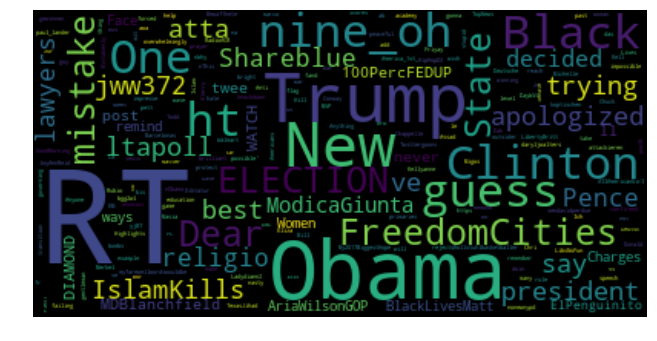

In [6]:
tweet_text = WordCloud().generate(str(tweets['text']))
# Display the generated image:
# the matplotlib way:
fig = plt.figure(figsize=(11,10))
axis1 = fig.add_subplot(111)
axis1.imshow(tweet_text, interpolation='bilinear')
axis1.axis("off")

(-0.5, 399.5, 199.5, -0.5)

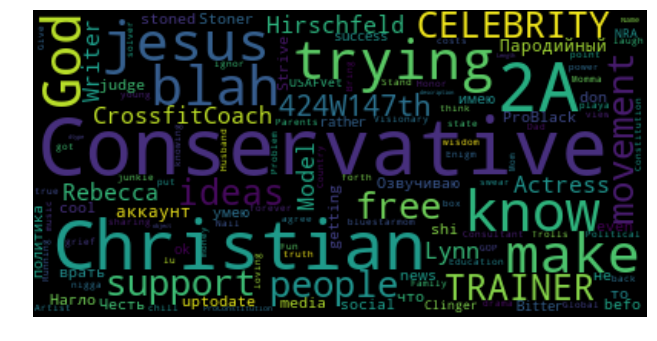

In [7]:
tweet_text = WordCloud().generate(str(twitter_user['description']))
# Display the generated image:
# the matplotlib way:
fig = plt.figure(figsize=(11,10))
axis1 = fig.add_subplot(111)
axis1.imshow(tweet_text, interpolation='bilinear')
axis1.axis("off")

(-0.5, 399.5, 199.5, -0.5)

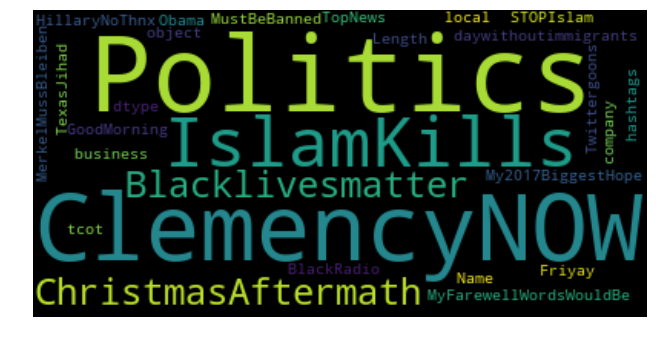

In [8]:
hashtags = WordCloud().generate(str(tweets['hashtags']))
# Display the generated image:
# the matplotlib way:
fig = plt.figure(figsize=(11,10))
axis2 = fig.add_subplot(111)
axis2.imshow(hashtags, interpolation='bilinear')
axis2.axis("off")